# Lane Detection

In [83]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [84]:
def grey(image):
  #convert to grayscale
    image = np.asarray(image)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  #Apply Gaussian Blur --> Reduce noise and smoothen image
def gauss(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

  #outline the strongest gradients in the image --> this is where lines in the image are
def canny(image):
    edges = cv2.Canny(image,50,150)
    return edges

# Isolate the region of interest in our image
def region(image):
    height, width = image.shape
    #isolate the gradients that correspond to the lane lines
    triangle = np.array([
                       [(100, height), (475, 325), (width, height)]
                       ])
    #create a black image with the same dimensions as original image
    mask = np.zeros_like(image)
    #create a mask (triangle that isolates the region of interest in our image)
    mask = cv2.fillPoly(mask, triangle, 255)
    mask = cv2.bitwise_and(image, mask)
    return mask

# Hough Transform --> detect lines in the image
def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    #make sure array isn't empty
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            #draw lines on a black image
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return lines_image

# Average the lines detected to create one line for each lane
def average(image, lines):
    left = []
    right = []

    if lines is not None:
      for line in lines:
        print(line)
        x1, y1, x2, y2 = line.reshape(4)
        #fit line to points, return slope and y-int
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        print(parameters)
        slope = parameters[0]
        y_int = parameters[1]
        #lines on the right have positive slope, and lines on the left have neg slope
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))
            
    #takes average among all the columns (column0: slope, column1: y_int)
    right_avg = np.average(right, axis=0)
    left_avg = np.average(left, axis=0)
    #create lines based on averages calculates
    left_line = make_points(image, left_avg)
    right_line = make_points(image, right_avg)
    return np.array([left_line, right_line])

# Create lines based on averages calculated
def make_points(image, average):
    print(average)
    slope, y_int = average
    y1 = image.shape[0]
    #how long we want our lines to be --> 3/5 the size of the image
    y2 = int(y1 * (3/5))
    #determine algebraically
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

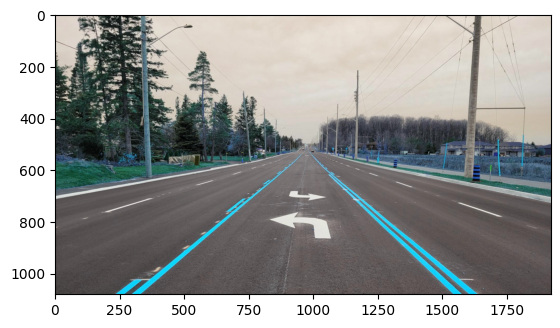

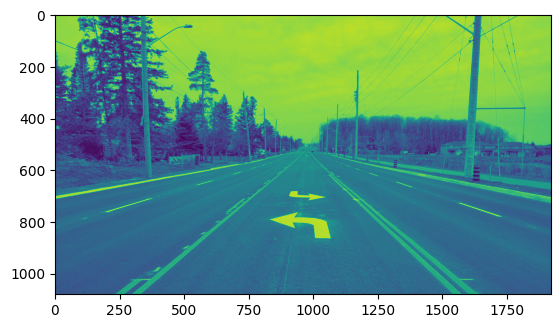

In [85]:
# Read Image
image_path = r"H:\Code\Phrojects\Robonautica_Rhapsody_IISc_2023\Lane Detection\road_lane_2.jpg"
img = cv2.imread(image_path)
plt.imshow(img)
plt.show()

# Convert to grayscale
gray_img = grey(img)
plt.imshow(gray_img)
plt.show()

# Copy image
copy_img = np.copy(gray_img)

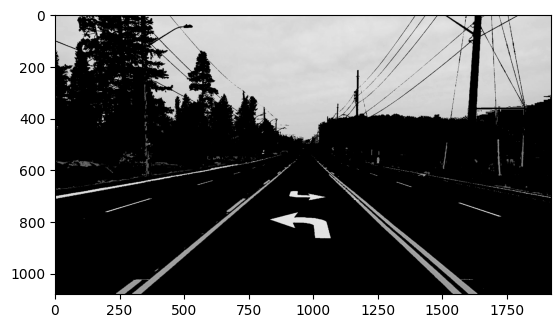

In [86]:
# HSV Image --> Hue, Saturation, Value
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([20, 100, 100], dtype = "uint8")
upper_yellow = np.array([30, 255, 255], dtype="uint8")

mask_yellow = cv2.inRange(hsv_img, lower_yellow, upper_yellow)
mask_white = cv2.inRange(gray_img, 200, 255)
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
mask_yw_img = cv2.bitwise_and(gray_img, mask_yw)

plt.imshow(mask_yw_img, cmap='gray')
plt.show()

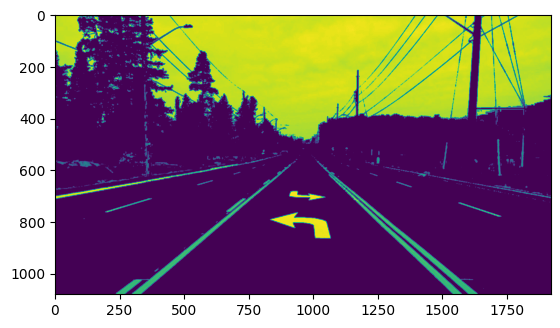

In [87]:
# Apply Gaussian Blur
blur_img = gauss(mask_yw_img)
plt.imshow(blur_img)
plt.show()

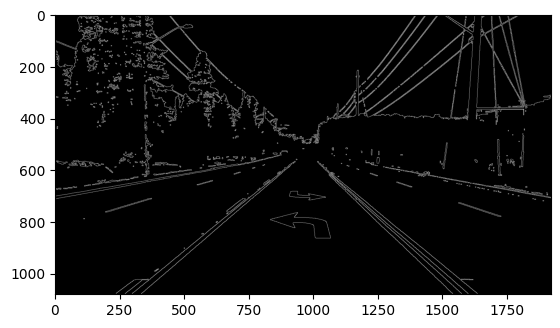

In [88]:
# Apply Canny Edge Detection
canny_img = canny(blur_img)
plt.imshow(canny_img, cmap='gray')
plt.show()

[[1057  607 1239  755]]
[   0.81318681 -252.53846154]
[[1350  864 1596 1078]]
[   0.8699187 -310.3902439]
[[1020  578 1072  625]]
[   0.90384615 -343.92307692]
[[518 897 827 646]]
[-8.12297735e-01  1.31777023e+03]
[[ 363 1053  559  883]]
[-8.67346939e-01  1.36784694e+03]
[[1320  285 1522  115]]
[-8.41584158e-01  1.39589109e+03]
[[1058  621 1292  847]]
[   0.96581197 -400.82905983]
[[1142  691 1570 1077]]
[   0.90186916 -338.93457944]
[[ 72 690 290 652]]
[-1.74311927e-01  7.02550459e+02]
[[1266  779 1307  812]]
[   0.80487805 -239.97560976]
[[1393  275 1444  237]]
[-7.45098039e-01  1.31292157e+03]
[[600 849 735 732]]
[-8.66666667e-01  1.36900000e+03]
[[1284  195 1367   89]]
[-1.27710843e+00  1.83480723e+03]
[[203 676 352 647]]
[-1.94630872e-01  7.15510067e+02]
[[1560  201 1569  140]]
[-6.77777778e+00  1.07743333e+04]
[[1498  630 1630  655]]
[1.89393939e-01 3.46287879e+02]
[[1419  259 1459  229]]
[-7.50000e-01  1.32325e+03]
[[121 691 248 667]]
[-1.88976378e-01  7.13866142e+02]
[[1701  28

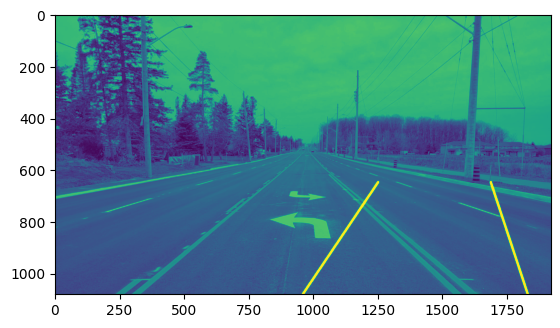

In [89]:
#DRAWING LINES: (order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array, 
lines = cv2.HoughLinesP(canny_img, 4, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines = average(copy_img, lines)
black_lines = display_lines(copy_img, averaged_lines)


#taking weighted sum of original image and lane lines image
lanes = cv2.addWeighted(copy_img, 0.8, black_lines, 1, 1)
plt.imshow(lanes)